# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Data Load

In [ ]:
!unzip -q round_imgs.zip; rm round_imgs.zip

In [ ]:
image_dir = Path('/content/round_imgs')

In [ ]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
images = pd.concat([filepaths, angles], axis = 1).sample(frac=1.0, random_state=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
## new
filepaths = pd.Series(list(image_dir.glob(r'train/*.jpg')), name='Filepath').astype(str)
angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
train_images = pd.concat([filepaths, angles], axis = 1).sample(frac=1.0, random_state=1).reset_index(drop=True)

filepaths = pd.Series(list(image_dir.glob(r'test/*.jpg')), name='Filepath').astype(str)
angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
test_images = pd.concat([filepaths, angles], axis = 1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
images

,Filepath,value
0,/content/round_imgs/8.4/220710_153637.jpg,8.4
1,/content/round_imgs/5.2/220710_152925.jpg,5.2
2,/content/round_imgs/11.2/220710_154323.jpg,11.2
3,/content/round_imgs/3.0/220710_152359.jpg,3.0
4,/content/round_imgs/8.2/220710_153614.jpg,8.2
...,...,...
285,/content/round_imgs/6.2/220710_153141.jpg,6.2
286,/content/round_imgs/4.6/220710_152802.jpg,4.6
287,/content/round_imgs/0.6/220710_151757.jpg,0.6
288,/content/round_imgs/1.8/220710_152111.jpg,1.8


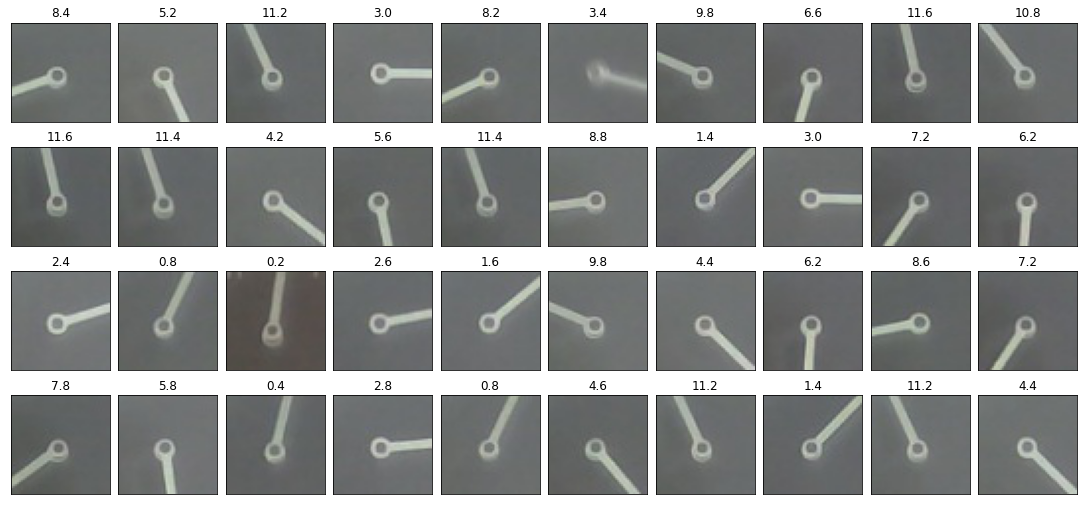

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images.Filepath[i]))
    ax.set_title(images.value[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(232, 2)
(58, 2)


In [ ]:
## new
print(train_images)
print(test_images)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255, 
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255
)

In [ ]:
## new
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='value',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    # save_to_dir= '..',
    # save_format = 'jpeg'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='value',
    target_size = (120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='value',
    target_size = (120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle = False
)

Found 186 validated image filenames.
Found 46 validated image filenames.
Found 58 validated image filenames.


In [ ]:
## new
train_images = train_generator.flow_from_dataframe(
    dataframe=train_images,
    x_col='Filepath',
    y_col='value',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    # save_to_dir= '..',
    # save_format = 'jpeg'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_images,
    x_col='Filepath',
    y_col='value',
    target_size = (120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle = False
)

# Model

In [ ]:

input_shape = (120,120,3)

input_tensor = layers.Input(shape = input_shape)

conv1_1 = layers.Conv2D(16, (3,3), padding='same', activation='relu')(input_tensor)
conv1_2 = layers.MaxPool2D()(conv1_1)

conv2_1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(conv1_2)
conv2_2 = layers.MaxPool2D()(conv2_1)

conv3_1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(conv2_2)
conv3_2 = layers.MaxPool2D()(conv3_1)

conv4_1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(conv3_2)
conv4_2 = layers.MaxPool2D()(conv4_1)

conv5_1 = layers.Conv2D(128, (3,3), padding='same', activation='relu')(conv4_2)
conv5_2 = layers.MaxPool2D()(conv5_1)

conv6_1 = layers.Conv2D(128, (3,3), padding='same', activation='relu')(conv5_2)
conv6_2 = layers.MaxPool2D()(conv6_1)

flatten = layers.Flatten()(conv6_2)
dense1 = layers.Dense(128, activation='relu')(flatten)
dense2 = layers.Dense(32, activation='relu')(dense1)
output_class = layers.Dense(1, activation='linear')(dense2)

res_model = models.Model(input_tensor, output_class)
res_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        18496 

# Loss Function

In [ ]:
def L1_loss(new_true_val, new_pred_val):
  pass

def min_loss(new_true_val, new_pred_val):
  new_thres_val = 1
  #error = new_true_val - new_pred_val
  new_true_val = float(new_true_val)
  new_true_val
  error1 = new_true_val - new_pred_val
  sub_num = tf.constant([12],dtype=float)
  error2 = sub_num - tf.abs(new_true_val - new_pred_val)
  if tf.less(error1, error2)[0]:
    error = error1
  else:
    error = error2
  smal_err = tf.abs(error) <= new_thres_val
  new_err_loss = tf.abs(error)/2
  max_err_loss = new_thres_val * (tf.abs(error) - new_thres_val / 2)
  return tf.where(smal_err, new_err_loss, max_err_loss)

def sin_loss(new_true_val, new_pred_val):
  pass

def cos_loss(new_true_val, new_pred_val):
  pass

# Train

In [ ]:
res_model.compile(optimizer='Adam', loss=min_loss)
history = res_model.fit(
    train_images, 
    epochs=1000,
)

# history = res_model.fit(
#     train_images, 
#     validation_data=val_images, 
#     epochs=100,
#     callbacks=[
#           tf.keras.callbacks.EarlyStopping(
#               monitor='val_loss',
#               patience=5,
#               restore_best_weights=True
#         )
#     ]
# )

# Result

In [ ]:
prediction_value = np.squeeze(res_model.predict(test_images))
true_value = test_images.labels

rmse = np.sqrt(res_model.evaluate(test_images, verbose=0))
print("Test RMSE : {:.5f}".format(rmse))

r2 = r2_score(true_value, prediction_value)
print("Test R^2 Score: {:.5f}".format(r2))

 Test RMSE : {:.5f} 0.5875818195589517
Test R^2 Score: 0.82559


In [ ]:
# null_rmse = np.sqrt(np.sum((true_value - np.mean(true_value))**2) / len(true_value))
# print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

In [ ]:
import cv2
for i in range(120):
  temp = images.Filepath[i]
  print(temp[20:23], end="  ")
  img2 = cv2.imread(temp)
  # int -> float
  scalingFactor = 1/255.0
  # Convert unsigned int 8bit to float
  img2 = np.float32(img2)
  img2 = img2*scalingFactor

  # input layer 형식 맞추기
  img2 = cv2.resize(img2, (120,120))
  img2 = img2.reshape(-1, 120, 120, 3)
  print(np.squeeze(res_model.predict(img2)))

5.2  5.3792634
11.  10.855408
3.4  3.6033728
6.8  6.436694
0.4  0.42957622
10.  10.515396
9.4  8.934474
6.0  5.661023
9.8  9.819306
10.  10.566939
9.4  8.926872
7.2  6.8439217
9.6  9.334879
4.8  4.6999345
7.2  6.800766
8.2  8.037854
6.6  6.247676
1.8  1.8863369
1.4  1.4725069
0.0  0.077977404
10.  9.811816
6.2  5.794218
0.8  0.84648496
11.  11.175922
6.4  6.1212726
9.4  8.860894
3.0  3.040698
8.0  7.998685
7.4  6.905611
8.4  8.222057
3.8  3.6938288
0.8  0.9141061
0.6  0.68540615
0.0  0.04046508
2.8  2.7627249
5.6  5.4061365
3.4  3.2536325
6.6  6.118689
3.4  3.3023674
1.6  1.6949216
3.0  2.9773204
4.0  3.7636893
1.2  1.2354542
9.0  8.594906
0.6  0.6818346
2.8  2.7810996
9.4  9.054872
0.6  0.6801557
0.0  0.04222958
11.  3.6117306
9.0  8.828242
5.0  4.9197006
4.6  4.443846
1.8  1.8458538
0.6  0.65655357
8.0  7.9468846
10.  9.76919
11.  10.678984
8.2  7.974386
9.6  9.785229
11.  11.400119
8.8  8.440622
3.6  3.4304483
1.2  1.2650979
4.4  4.2663064
10.  9.88651
10.  10.294941
11.  10.752502


# Model Save

In [ ]:
res_model.save('my_model_17.h5')